<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/importing_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to import COCO annotations into Kili

In this tutorial, we will demonstrate how to import [COCO](https://cocodataset.org/) annotations into Kili.

## Setup

Let's start by installing Kili:

In [ ]:
%pip install kili numpy opencv-python

In [ ]:
import getpass
import json
import os
from pprint import pprint

import numpy as np

from kili.client import Kili

## Data collection

We will use the [COCO dataset](https://cocodataset.org/) to illustrate how to import COCO annotations into Kili.

For this tutorial, we will use a subset of the `val2017` dataset. The full dataset can be downloaded [here](https://cocodataset.org/#download).

In [ ]:
!curl https://raw.githubusercontent.com/kili-technology/kili-python-sdk/main/recipes/datasets/coco2017/annotations/captions_val2017_filtered.json --output captions_val2017_filtered.json
!curl https://raw.githubusercontent.com/kili-technology/kili-python-sdk/main/recipes/datasets/coco2017/annotations/instances_val2017_filtered.json --output instances_val2017_filtered.json
!curl https://raw.githubusercontent.com/kili-technology/kili-python-sdk/main/recipes/datasets/coco2017/annotations/person_keypoints_val2017_filtered.json --output person_keypoints_val2017_filtered.json

## COCO format

The format is described [here](https://cocodataset.org/#format-data).

The file `instances_val2017_filtered.json` contains the following keys:

In [ ]:
instances_val2017 = json.load(open("instances_val2017_filtered.json"))
print(instances_val2017.keys())

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses'])


Each annotation contains a the image id to which it belongs, the category id, the segmentation and the bounding box:

In [ ]:
pprint(instances_val2017["annotations"][0])

{'area': 88.52115000000006,
 'bbox': [102.49, 118.47, 7.9, 17.31],
 'category_id': 64,
 'id': 22328,
 'image_id': 37777,
 'iscrowd': 0,
 'segmentation': [[110.39,
                   135.78,
                   110.39,
                   127.62,
                   110.01,
                   119.6,
                   106.87,
                   118.47,
                   104.37,
                   120.1,
                   102.49,
                   122.73,
                   103.74,
                   125.49,
                   105.24,
                   128.88,
                   106.87,
                   132.39,
                   107.38,
                   135.78,
                   110.39,
                   135.65]]}


We can print the categories of COCO this way:

In [ ]:
for category in instances_val2017["categories"]:
    print(category["id"], category["name"])

1 person
2 bicycle
3 car
4 motorcycle
5 airplane
6 bus
7 train
8 truck
9 boat
10 traffic light
11 fire hydrant
13 stop sign
14 parking meter
15 bench
16 bird
17 cat
18 dog
19 horse
20 sheep
21 cow
22 elephant
23 bear
24 zebra
25 giraffe
27 backpack
28 umbrella
31 handbag
32 tie
33 suitcase
34 frisbee
35 skis
36 snowboard
37 sports ball
38 kite
39 baseball bat
40 baseball glove
41 skateboard
42 surfboard
43 tennis racket
44 bottle
46 wine glass
47 cup
48 fork
49 knife
50 spoon
51 bowl
52 banana
53 apple
54 sandwich
55 orange
56 broccoli
57 carrot
58 hot dog
59 pizza
60 donut
61 cake
62 chair
63 couch
64 potted plant
65 bed
67 dining table
70 toilet
72 tv
73 laptop
74 mouse
75 remote
76 keyboard
77 cell phone
78 microwave
79 oven
80 toaster
81 sink
82 refrigerator
84 book
85 clock
86 vase
87 scissors
88 teddy bear
89 hair drier
90 toothbrush


The file `captions_val2017_filtered.json` contains transcription data:

In [ ]:
captions_val2017 = json.load(open("captions_val2017_filtered.json"))
print(captions_val2017.keys())

dict_keys(['annotations', 'images', 'info', 'licenses'])


In [ ]:
print(captions_val2017["annotations"][0])

{'caption': 'A small closed toilet in a cramped space.', 'id': 441, 'image_id': 331352}


In this dataset, each image has 5 captions given by different annotators.

The file `person_keypoints_val2017_filtered.json` contains keypoints data:

In [ ]:
person_keypoints_val2017 = json.load(open("person_keypoints_val2017_filtered.json"))
print(person_keypoints_val2017.keys())

dict_keys(['annotations', 'categories', 'images', 'info', 'licenses'])


In [ ]:
pprint(person_keypoints_val2017["annotations"][0])

{'area': 17376.91885,
 'bbox': [388.66, 69.92, 109.41, 277.62],
 'category_id': 1,
 'id': 200887,
 'image_id': 397133,
 'iscrowd': 0,
 'keypoints': [433,
               94,
               2,
               434,
               90,
               2,
               0,
               0,
               0,
               443,
               98,
               2,
               0,
               0,
               0,
               420,
               128,
               2,
               474,
               133,
               2,
               396,
               162,
               2,
               489,
               173,
               2,
               0,
               0,
               0,
               0,
               0,
               0,
               419,
               214,
               2,
               458,
               215,
               2,
               411,
               274,
               2,
               458,
               273,
               2,
               

## Kili project creation

Let's create the Kili project that will contain the images and annotations of the COCO dataset.

In [ ]:
if "KILI_API_KEY" not in os.environ:
    KILI_API_KEY = getpass.getpass("Please enter your API key: ")
else:
    KILI_API_KEY = os.environ["KILI_API_KEY"]

Below, we initialize the Kili client:

In [ ]:
kili = Kili(
    api_key=KILI_API_KEY,  # no need to pass the API_KEY if it is already in your environment variables
    # api_endpoint="https://cloud.kili-technology.com/api/label/v2/graphql",
    # the line above can be uncommented and changed if you are working with an on-premise version of Kili
)

The `json_interface` variable contains the ontology of the project. 

In [ ]:
json_interface = {"jobs": {}}

We start by defining the transcription job, that aims describing the image content:

In [ ]:
json_interface["jobs"]["TRANSCRIPTION_JOB"] = {
    "content": {"input": "textField"},
    "instruction": "Caption",
    "mlTask": "TRANSCRIPTION",
    "required": 0,
    "isChild": False,
}

In the dictionary below, we map the category ids to the category names:

In [ ]:
category_id_to_name = {
    category["id"]: category["name"] for category in instances_val2017["categories"]
}

In [ ]:
categories = {
    category["name"]: {"children": [], "name": category["name"], "id": category["id"]}
    for category in instances_val2017["categories"]
}

We also define object detection jobs:

In [ ]:
json_interface["jobs"]["OBJECT_DETECTION_JOB"] = {
    "content": {"categories": categories, "input": "radio"},
    "instruction": "BBox",
    "mlTask": "OBJECT_DETECTION",
    "required": 0,
    "tools": ["rectangle"],
    "isChild": False,
}

In [ ]:
json_interface["jobs"]["SEGMENTATION_JOB"] = {
    "content": {"categories": categories, "input": "radio"},
    "instruction": "Segment",
    "mlTask": "OBJECT_DETECTION",
    "required": 0,
    "tools": ["semantic"],
    "isChild": False,
}

And a pose estimation job:

In [ ]:
map_key_cat_to_body_part = {
    "nose": "face",
    "left_eye": "face",
    "right_eye": "face",
    "left_ear": "face",
    "right_ear": "face",
    "left_shoulder": "upper_body_left",
    "right_shoulder": "upper_body_right",
    "left_elbow": "upper_body_left",
    "right_elbow": "upper_body_right",
    "left_wrist": "upper_body_left",
    "right_wrist": "upper_body_right",
    "left_hip": "lower_body_left",
    "right_hip": "lower_body_right",
    "left_knee": "lower_body_left",
    "right_knee": "lower_body_right",
    "left_ankle": "lower_body_left",
    "right_ankle": "lower_body_right",
}

In [ ]:
json_interface["jobs"]["POSE_ESTIMATION_JOB"] = {
    "content": {
        "categories": {
            "face": {
                "children": [],
                "name": "face",
                "points": [
                    {"code": "nose", "name": "nose"},
                    {"code": "left_eye", "name": "left_eye"},
                    {"code": "right_eye", "name": "right_eye"},
                    {"code": "left_ear", "name": "left_ear"},
                    {"code": "right_ear", "name": "right_ear"},
                ],
            },
            "upper_body_left": {
                "children": [],
                "name": "upper_body_left",
                "points": [
                    {"code": "left_shoulder", "name": "left_shoulder"},
                    {"code": "left_elbow", "name": "left_elbow"},
                    {"code": "left_wrist", "name": "left_wrist"},
                ],
            },
            "upper_body_right": {
                "children": [],
                "name": "upper_body_right",
                "points": [
                    {"code": "right_shoulder", "name": "right_shoulder"},
                    {"code": "right_elbow", "name": "right_elbow"},
                    {"code": "right_wrist", "name": "right_wrist"},
                ],
            },
            "lower_body_left": {
                "children": [],
                "name": "lower_body_left",
                "points": [
                    {"code": "left_hip", "name": "left_hip"},
                    {"code": "left_knee", "name": "left_knee"},
                    {"code": "left_ankle", "name": "left_ankle"},
                ],
            },
            "lower_body_right": {
                "children": [],
                "name": "lower_body_right",
                "points": [
                    {"code": "right_hip", "name": "right_hip"},
                    {"code": "right_knee", "name": "right_knee"},
                    {"code": "right_ankle", "name": "right_ankle"},
                ],
            },
        },
        "input": "radio",
    },
    "instruction": "Pose estimation",
    "mlTask": "OBJECT_DETECTION",
    "required": 0,
    "tools": ["pose"],
    "isChild": False,
}

In [ ]:
project = kili.create_project(
    title="[Kili SDK Notebook]: COCO 2017",
    input_type="IMAGE",
    json_interface=json_interface,
)

## Importing images

Now that our project is created, let's import the images:

In [ ]:
content_array = []
external_id_array = []
for image in instances_val2017["images"]:
    content_array.append(image["flickr_url"].replace("http://", "https://"))
    external_id_array.append(str(image["id"]))

In [ ]:
kili.append_many_to_dataset(
    project["id"], content_array=content_array, external_id_array=external_id_array
)

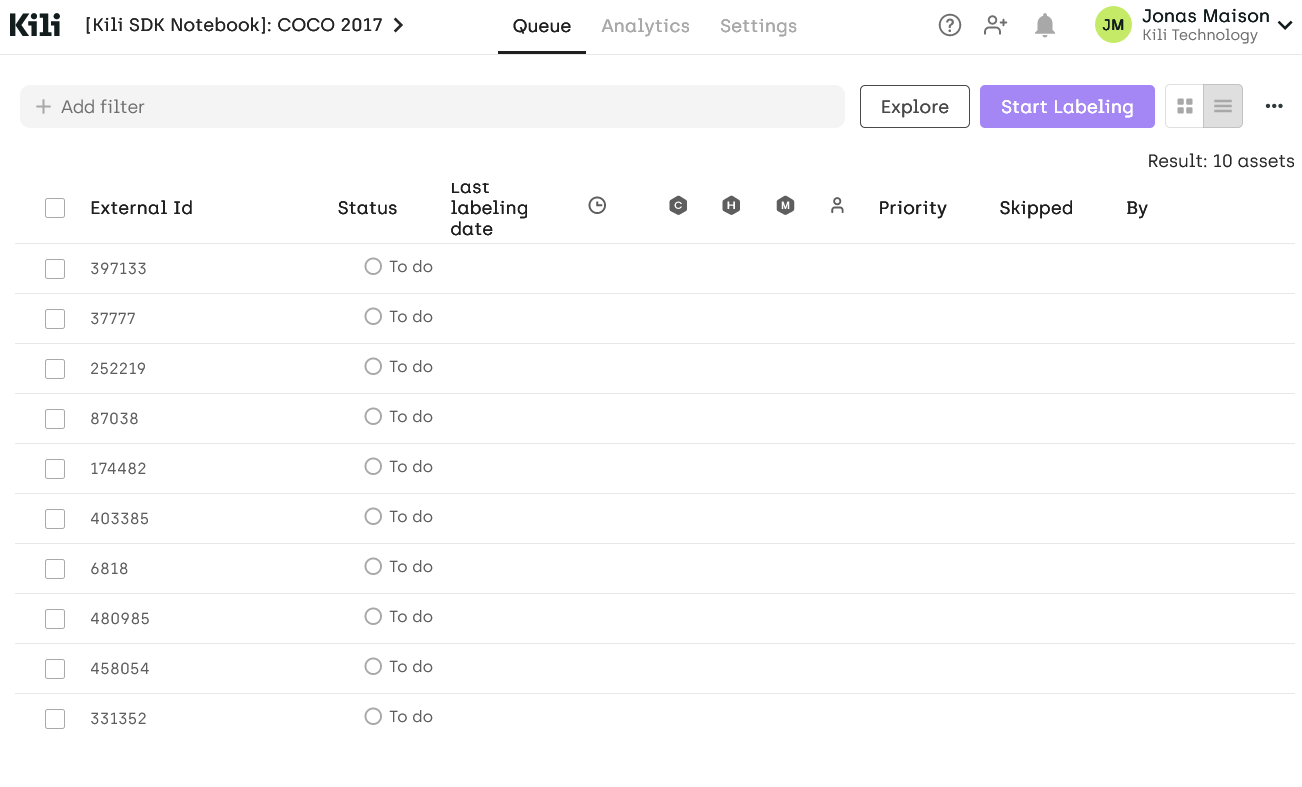

## Importing annotations

Below, we import some useful functions to convert annotations to Kili label format:

In [ ]:
from typing import Dict, List

from kili.utils.labels.bbox import (
    bbox_points_to_normalized_vertices,
    point_to_normalized_point,
)
from kili.utils.labels.image import mask_to_normalized_vertices

In [ ]:
def coco_bbox_annotation_to_normalized_vertices(
    coco_ann: Dict, *, img_width: int, img_height: int
) -> List[Dict]:
    x, y, width, height = coco_ann["bbox"]
    ret = bbox_points_to_normalized_vertices(
        bottom_left={"x": x, "y": y + height},
        bottom_right={"x": x + width, "y": y + height},
        top_right={"x": x + width, "y": y},
        top_left={"x": x, "y": y},
        img_height=img_height,
        img_width=img_width,
        origin_location="top_left",
    )
    return ret

In [ ]:
def coco_segm_annotation_to_normalized_vertices(
    coco_ann: Dict, *, img_width: int, img_height: int
) -> List[List[Dict]]:
    coco_segmentations = coco_ann["segmentation"]

    ret = []
    for coco_segm in coco_segmentations:
        if coco_ann["iscrowd"] == 0:
            # a single object (iscrowd=0 in which case polygons are used)[
            vertices = [
                point_to_normalized_point(
                    point={"x": x, "y": y},
                    img_height=img_height,
                    img_width=img_width,
                    origin_location="top_left",
                )
                for x, y in zip(coco_segm[::2], coco_segm[1::2])
            ]
            ret.append(vertices)

        else:
            # a crowd (iscrowd=1 in which case RLE (run-length encoding) is used)
            rle_counts = coco_segmentations["counts"]
            mask = np.zeros(img_height * img_width, dtype=np.uint8)  # flat image
            pixel_index = 0
            for i, count in enumerate(rle_counts):
                if i % 2 == 1:
                    # we set pixels' value
                    mask[pixel_index : pixel_index + count] = 255
                pixel_index += count

            # we reshape the mask to its original shape
            # and we transpose it to have the same shape as the image
            # (i.e. (height, width))
            mask = mask.reshape((img_width, img_height)).T

            # we convert the mask to normalized vertices
            # hierarchy is not used here. It is used for polygons with holes.
            normalized_vertices, hierarchy = mask_to_normalized_vertices(mask)
            ret.extend(normalized_vertices)

    return ret

In [ ]:
json_response_array = []

for image_id in external_id_array:
    img_info = [img for img in instances_val2017["images"] if img["id"] == int(image_id)][0]
    img_width = img_info["width"]
    img_height = img_info["height"]

    # json response contains the label data for the image
    json_resp = {}

    ### Transcription job
    img_captions = [
        ann for ann in captions_val2017["annotations"] if ann["image_id"] == int(image_id)
    ]
    json_resp["TRANSCRIPTION_JOB"] = {
        "text": img_captions[0]["caption"]  # we only take the 1st caption for sake of simplicity
    }

    ### Object detection and segmentation annotations
    coco_annotations = [
        ann for ann in instances_val2017["annotations"] if ann["image_id"] == int(image_id)
    ]
    kili_bbox_annotations = []
    kili_segm_annotations = []
    for coco_ann in coco_annotations:
        ### Object detection job
        if coco_ann["iscrowd"] == 0:
            # we skip crowd annotations bbox since they tend to be very large
            kili_bbox_ann = {
                "children": {},
                "boundingPoly": [
                    {
                        "normalizedVertices": coco_bbox_annotation_to_normalized_vertices(
                            coco_ann, img_width=img_width, img_height=img_height
                        )
                    }
                ],
                "categories": [{"name": category_id_to_name[coco_ann["category_id"]]}],
                "type": "rectangle",
                "mid": str(coco_ann["id"]) + "_bbox",
            }
            kili_bbox_annotations.append(kili_bbox_ann)

        ### Segmentation job
        for i, norm_vertices in enumerate(
            coco_segm_annotation_to_normalized_vertices(
                coco_ann, img_width=img_width, img_height=img_height
            )
        ):
            kili_segm_ann = {
                "children": {},
                "boundingPoly": [{"normalizedVertices": norm_vertices}],
                "categories": [{"name": category_id_to_name[coco_ann["category_id"]]}],
                "type": "semantic",
                "mid": str(coco_ann["id"]) + "_segm_" + str(i),
            }
            kili_segm_annotations.append(kili_segm_ann)

    ### Pose estimation annotations
    coco_annotations = [
        ann for ann in person_keypoints_val2017["annotations"] if ann["image_id"] == int(image_id)
    ]
    kili_keypoints_annotations = []
    for coco_ann in coco_annotations:
        keypoints = coco_ann["keypoints"]
        for body_part in (
            "face",
            "upper_body_left",
            "upper_body_right",
            "lower_body_left",
            "lower_body_right",
        ):
            kili_keypoint_ann = {
                "categories": [{"name": body_part}],
                "children": {},
                "jobName": "POSE_ESTIMATION_JOB",
                "kind": "POSE_ESTIMATION",
                "mid": str(coco_ann["id"]) + "_keypoints_" + body_part,
                "points": [],
                "type": "marker",
            }
            for x, y, visibility, point_type in zip(
                keypoints[::3],
                keypoints[1::3],
                keypoints[2::3],
                person_keypoints_val2017["categories"][0]["keypoints"],
            ):
                if x == y == visibility == 0:
                    continue
                if map_key_cat_to_body_part[point_type] != body_part:
                    continue
                kili_keypoint_ann["points"].append(
                    {
                        "categories": [{"name": point_type}],
                        "children": {},
                        "code": point_type,
                        "jobName": "POSE_ESTIMATION_JOB",
                        "mid": str(coco_ann["id"]) + "_keypoints_" + point_type,
                        "name": point_type,
                        "point": point_to_normalized_point(
                            point={"x": x, "y": y},
                            img_height=img_height,
                            img_width=img_width,
                            origin_location="top_left",
                        ),
                    }
                )

            kili_keypoints_annotations.append(kili_keypoint_ann)

    json_resp["OBJECT_DETECTION_JOB"] = {"annotations": kili_bbox_annotations}
    json_resp["SEGMENTATION_JOB"] = {"annotations": kili_segm_annotations}
    json_resp["POSE_ESTIMATION_JOB"] = {"annotations": kili_keypoints_annotations}

    json_response_array.append(json_resp)

In [ ]:
kili.append_labels(
    asset_external_id_array=external_id_array,
    project_id=project["id"],
    json_response_array=json_response_array,
)

In Kili labeling interface, we can see the images and the annotations:

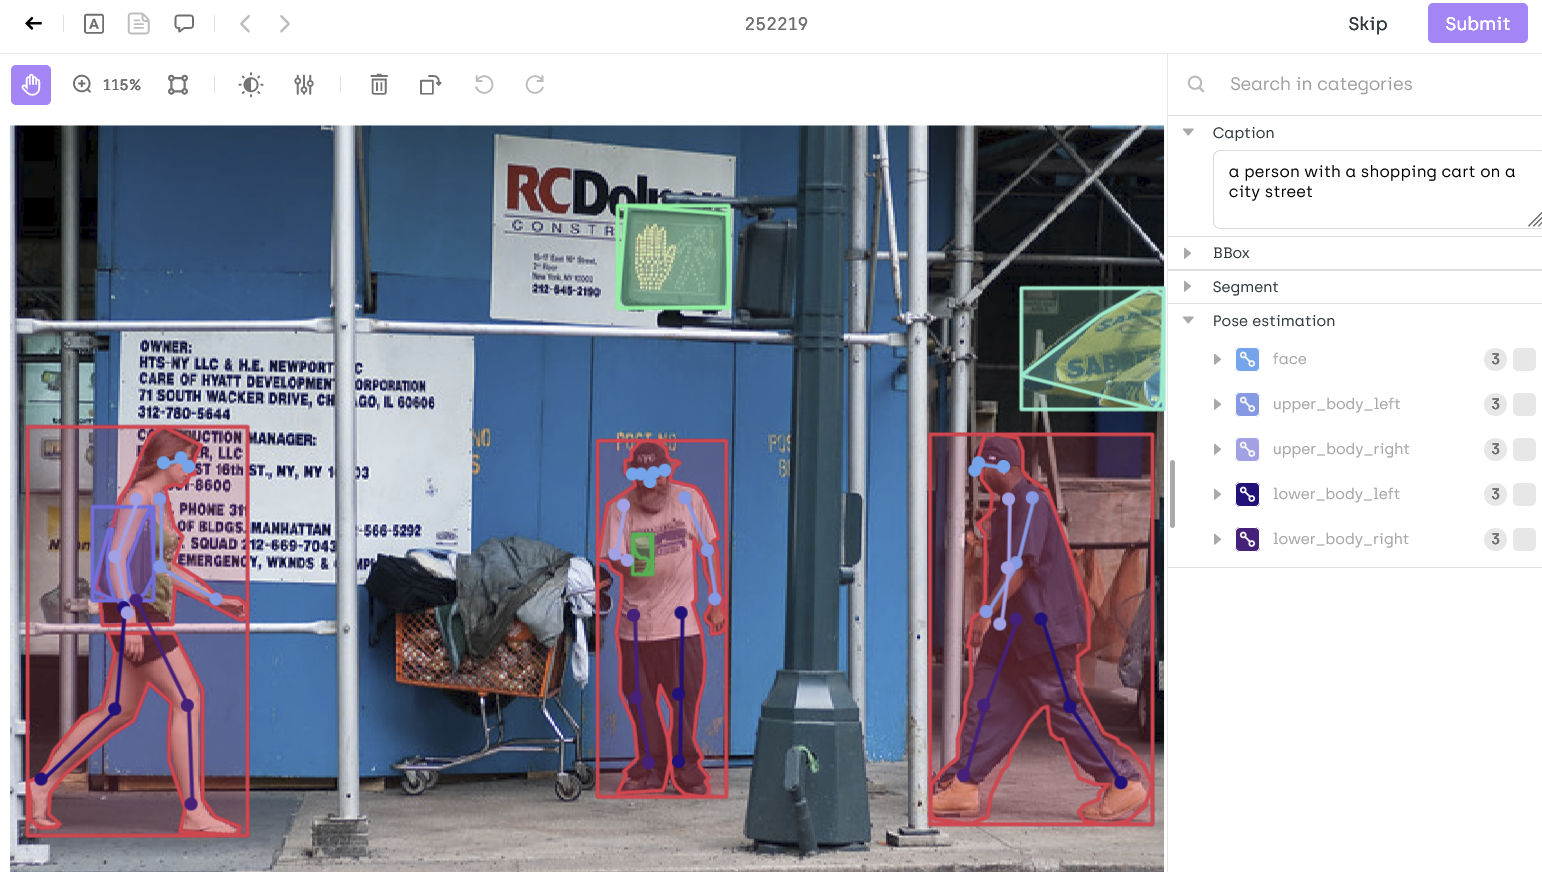

## Conclusion

In this tutorial, we have seen how to import COCO annotations into Kili.

You can now use Kili to refine and review your annotations, in order to train your machine learning models on high quality data.

## Cleaning up

In [ ]:
kili.delete_project(project_id=project["id"])